In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
np.set_printoptions(suppress=True)
import PIL
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch_snippets import Report
import os
import time
import pandas as pd

In [2]:
device = torch.device("cuda")

## First we build our dataloader

In [3]:
import glob
paths = glob.glob("MOT20Det\\train\\*\\img1\\*.jpg")


In [4]:
import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    """
    Composes several torchvision image transforms 
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [5]:
def get_transform(train):
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)

In [6]:
gt_paths = glob.glob("MOT20Det\\train\\*\\gt\\*.txt")

col_names = ['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'raw_conf', 'label', 'conf',]

label_df = None
for gt_path in gt_paths:
    tmp_df = pd.read_csv(gt_path, delimiter=',', names=col_names)
    tmp_df['seqname'] = gt_path.split('\\')[2]

    if label_df is None:
        label_df = tmp_df
    else:
        label_df = pd.concat((label_df, tmp_df))

In [7]:
label_df

,frame,id,bb_left,bb_top,bb_width,bb_height,raw_conf,label,conf,seqname
0,722,1,547,252,68,145,1,1,0.092317,MOT20-02
1,723,1,548,252,68,145,1,1,0.092317,MOT20-02
2,724,1,550,252,68,145,1,1,0.089339,MOT20-02
3,725,1,552,252,68,145,1,1,0.089339,MOT20-02
4,726,1,554,252,68,145,1,1,0.086361,MOT20-02
...,...,...,...,...,...,...,...,...,...,...
202210,2778,296,2,1,326,594,0,11,1.000000,MOT20-02
202211,2779,296,2,1,332,595,0,11,1.000000,MOT20-02
202212,2780,296,2,1,339,597,0,11,1.000000,MOT20-02
202213,2781,296,2,1,346,598,0,11,1.000000,MOT20-02


In [8]:
frame = 1
seqname = 'MOT20-01'
ann = label_df[(label_df.seqname == seqname) & (label_df.frame == frame) ]

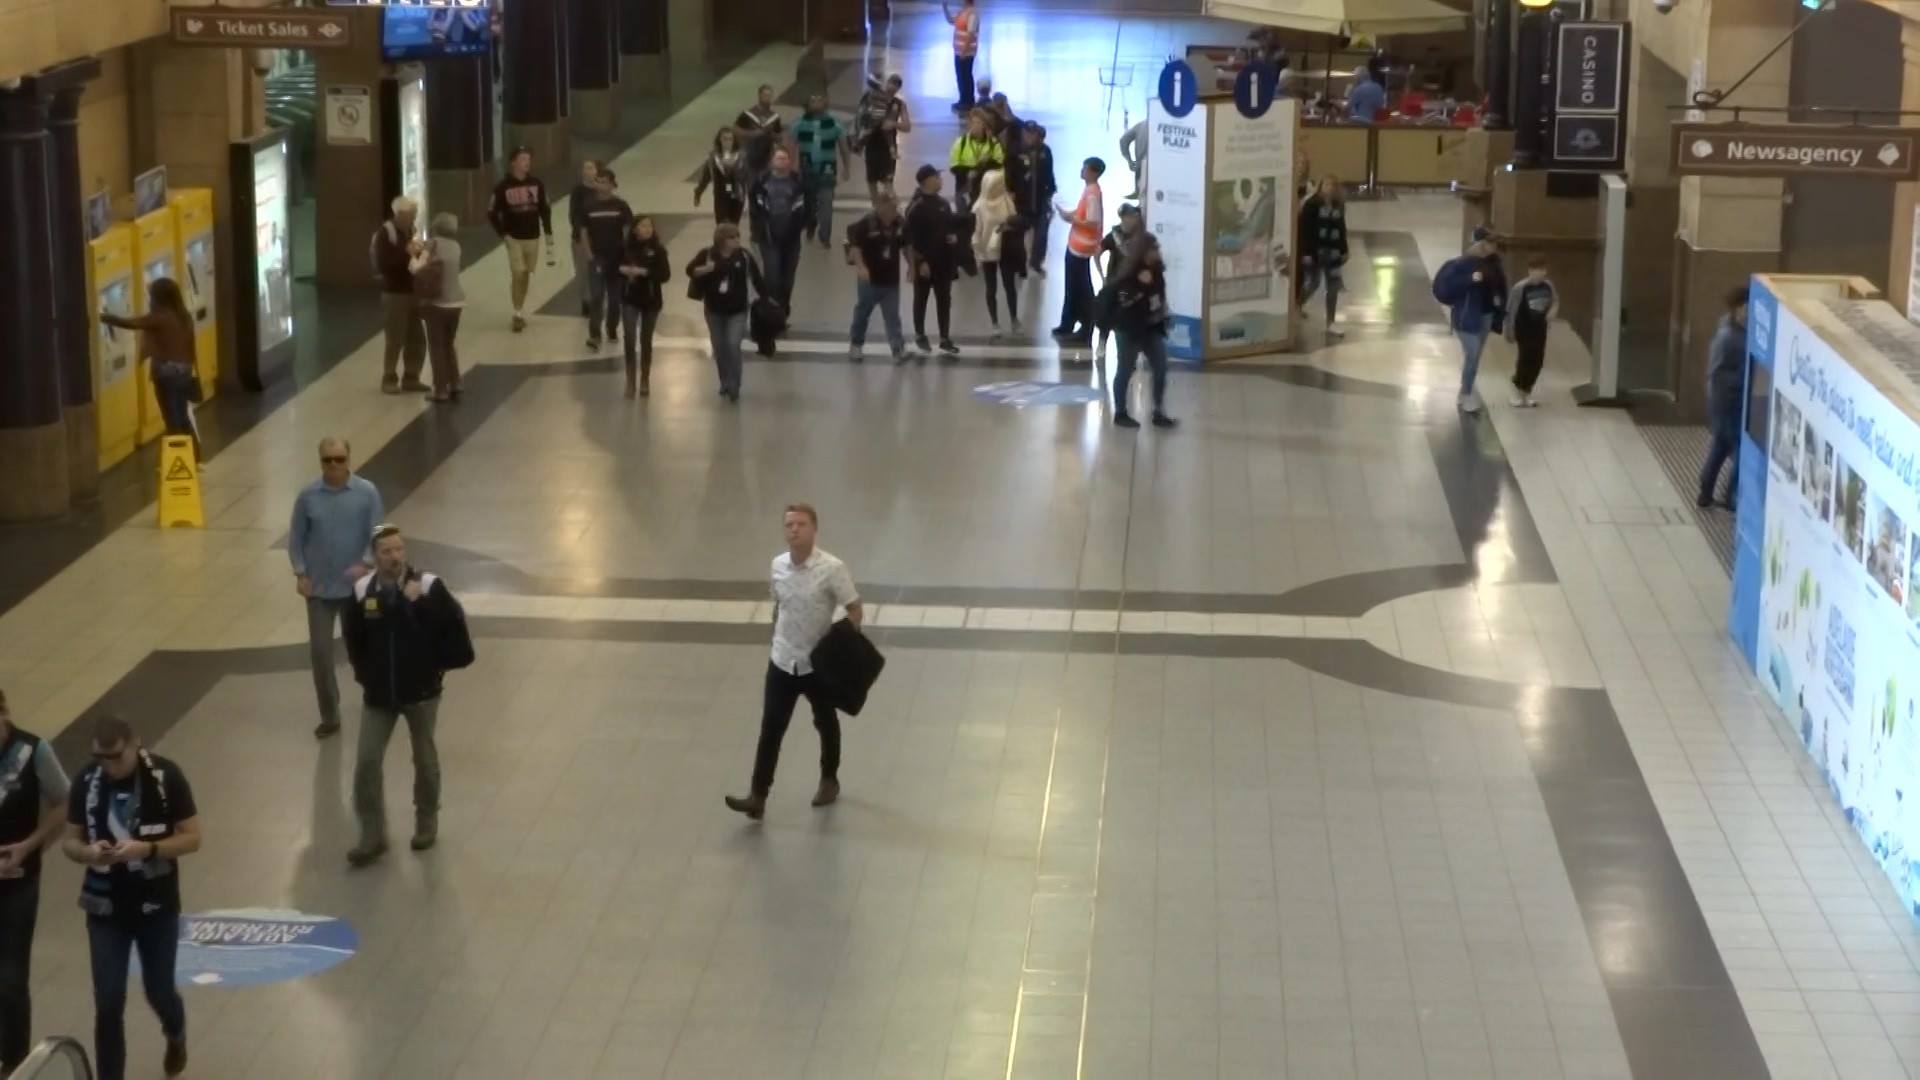

In [9]:
PIL.Image.open(paths[0]).convert("RGB")

In [10]:
x1 = ann['bb_left'].to_numpy()
x2 = ann['bb_left'].to_numpy() + ann['bb_width'].to_numpy()
y1 = ann['bb_top'].to_numpy()
y2 = ann['bb_top'].to_numpy() + ann['bb_height'].to_numpy()

In [11]:
np.array([x1,y1,x2,y2])

array([], shape=(4, 0), dtype=int64)

In [8]:
col_names=["frame","id","bb_left", "bb_top", "bb_width", "bb_height","conf"]


class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        # the root folder
        self.root = root

        # transformation for images
        self.transforms = transforms

        self.files = glob.glob("MOT20Det\\train\\MOT20-02\\img1\\*.jpg")

        self.label_df = None
        

        gt_paths = glob.glob("MOT20Det\\train\\MOT20-02\\gt\\*.txt")
        col_names = ['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'raw_conf', 'label', 'conf',]
        for gt_path in gt_paths:
            tmp_df = pd.read_csv(gt_path, delimiter=',', names=col_names)
            tmp_df['seqname'] = gt_path.split('\\')[2]
        
            if self.label_df is None:
                self.label_df = tmp_df
            else:
                self.label_df = pd.concat((label_df, tmp_df))
                
        self.label_df.loc[self.label_df.label != 1, 'label'] = 0
    
    
    def __getitem__(self,i):
        img_path = self.files[i]
        seqname, frame = img_path.split('\\')[2], int(img_path.split('\\')[4].replace('.jpg', ''))
        # load image
        img = PIL.Image.open(self.files[i]).convert("RGB")
        # load annotations
        ann = self.label_df[(self.label_df.seqname == seqname) & (self.label_df.frame == frame) ]
        # make dictionary of targets
        target = {}
        # boxes, labels, image_id
        x1 = ann['bb_left'].to_numpy()
        x2 = ann['bb_left'].to_numpy() + ann['bb_width'].to_numpy()
        y1 = ann['bb_top'].to_numpy()
        y2 = ann['bb_top'].to_numpy() + ann['bb_height'].to_numpy()
        
        target['boxes'] = torch.as_tensor(np.array([x1,y1,x2,y2]).T, dtype=torch.float32) / 2

        target['labels'] = torch.as_tensor(ann['label'].to_numpy(), dtype=torch.int64)
        
        target['image_id'] = torch.as_tensor(i, dtype=torch.float32)

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target

    def __len__(self):
        return len(self.files)

        

### Define Custom Transform here

In [13]:
from torchvision.transforms import v2


In [14]:
from torchvision.transforms import v2
import torchvision.transforms.functional as F

transform_train = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((540,960)),
    v2.ToDtype(torch.float32),
    lambda x, y: (x/255, y)
])

dataset = Dataset("./", transform_train)


In [15]:
# Collate image-target pairs into a tuple.
def collate_fn(batch):
    return tuple(zip(*batch))
dataloader = torch.utils.data.DataLoader(dataset, 
                                 batch_size = 1, 
                                 shuffle = False,
                                     collate_fn = collate_fn)

NameError: name 'dataloader' is not defined

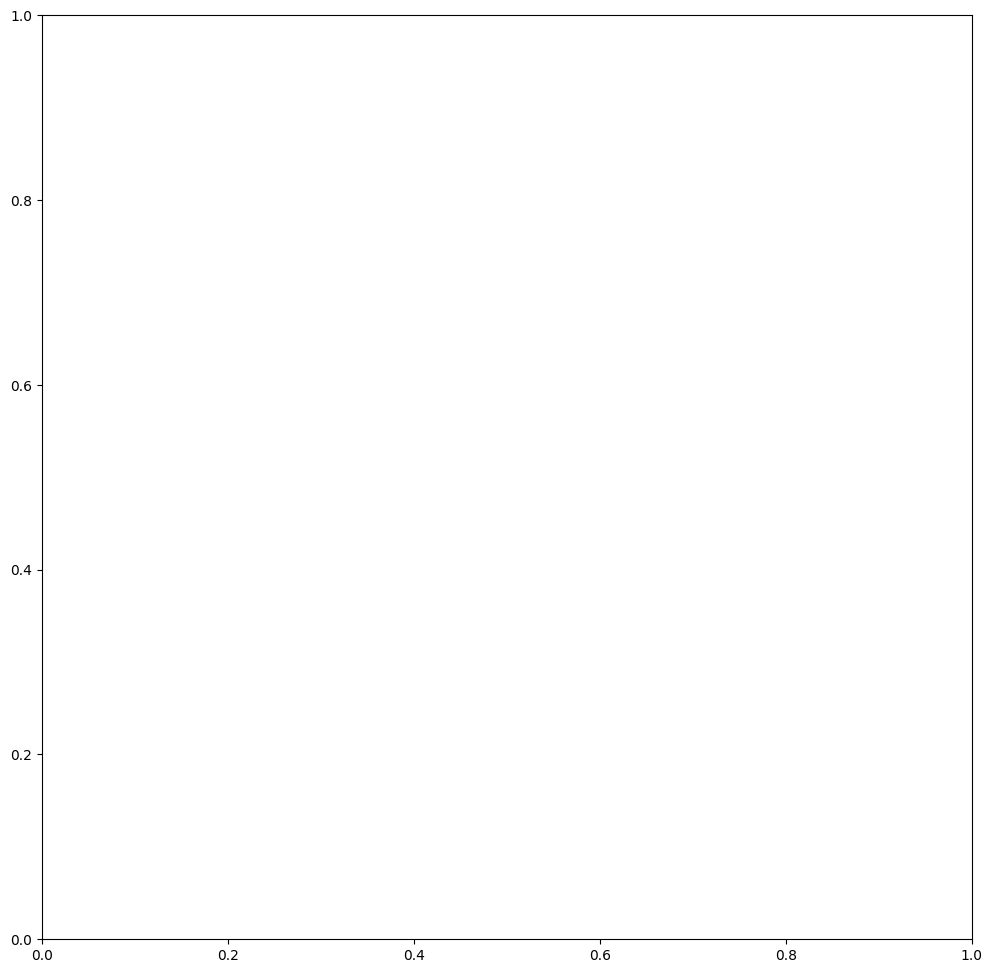

In [9]:
fig, ax = plt.subplots(figsize = [12, 12])
img, target = next(iter(dataloader))
ax.imshow(img[0].permute(1, 2, 0).numpy(), interpolation='none' )
for i, b in enumerate(target[0]['boxes'].numpy()):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
                b[1].astype(int) - 5,
                "{}".format(target[0]['labels'][i], color = "r"))


So far We have the data loader ready tran_ds <br>
We checked the bounding boxes matches pedestrians <br>
Now split train test 


In [17]:
indices = torch.randperm(len(dataset)).tolist()

indices = indices[:320]
len(indices)

320

In [18]:
# Randomly shuffle all the data.

# Train dataset: 64% of the entire data, or 80% of 80%.
train_dataset = torch.utils.data.Subset(dataset,
           indices[:int(len(indices) * 0.8)])

test_dataset = torch.utils.data.Subset(dataset,
           indices[int(len(indices) * 0.8):])

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                 batch_size = 16, 
                                 shuffle = False, 
                                collate_fn = collate_fn)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                               batch_size = 8, 
                              shuffle = False, 
                              collate_fn = collate_fn)

((tensor([[[0.67451, 0.67451, 0.67451,  ..., 0.70980, 0.70588, 0.70980],
           [0.69804, 0.70196, 0.70588,  ..., 0.70980, 0.70588, 0.70980],
           [0.72157, 0.72549, 0.72549,  ..., 0.68627, 0.69020, 0.69412],
           ...,
           [0.23922, 0.24314, 0.24314,  ..., 0.78431, 0.77255, 0.78039],
           [0.23922, 0.24314, 0.24314,  ..., 0.79216, 0.78431, 0.78431],
           [0.23922, 0.24314, 0.24314,  ..., 0.79608, 0.78824, 0.78824]],
  
          [[0.55686, 0.55294, 0.55294,  ..., 0.61176, 0.60784, 0.60784],
           [0.58039, 0.58431, 0.58824,  ..., 0.61176, 0.60784, 0.60784],
           [0.60000, 0.60392, 0.60392,  ..., 0.57647, 0.58039, 0.58431],
           ...,
           [0.20784, 0.21176, 0.21569,  ..., 0.83922, 0.82745, 0.83137],
           [0.20784, 0.21176, 0.21569,  ..., 0.84706, 0.83922, 0.83922],
           [0.20784, 0.21176, 0.21569,  ..., 0.85098, 0.84314, 0.84314]],
  
          [[0.32157, 0.32549, 0.32941,  ..., 0.45490, 0.45490, 0.45882],
           

# Let's define the model. 
We use the FASTRCNN with resnet50 feature extractor. <br>
The feature extraction layer will be frozen. <br> 
We train on Predictor layer <br>
We also change the number of output in the class predictor layer to 2. (Human and Background)

In [19]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2 as fasterrcnn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [20]:
model = fasterrcnn(pretrained = True)

for p in model.backbone.parameters():
    p.requires_grad = False


in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats,
                                                   2)

C:\Users\sali632\.conda\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sali632\.conda\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
"Total number of model parameters", sum([p.flatten().shape[0] for p in model.parameters()])

('Total number of model parameters', 43256153)

In [22]:
"Total number of model parameters to be trained", sum([p.flatten().shape[0] for p in model.parameters() if p.requires_grad])

('Total number of model parameters to be trained', 16401689)

# Training the model. 

In [29]:
device

device(type='cuda')

In [23]:
# Use the stochastic gradient descent optimizer.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                        lr = 0.01, 
                    momentum = 0.9, 
             weight_decay = 0.0005)


In [31]:
from torch_snippets import Report

In [32]:
from tqdm import tqdm
from torchmetrics.detection import IntersectionOverUnion
metric = IntersectionOverUnion()

In [158]:

model.to(device)
n_epochs = 100

log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for ix, batch in tqdm(enumerate(train_loader)):
        model.train()
        X,y = batch
        # move batch to device
        X = [x.to(device) for x in X]
        y = [{k: v.to(device) for k, v in t.items()} for t in y]

        # zero grads
        optimizer.zero_grad()
        losses = model(X,y)
        loss = sum(loss for loss in losses.values())

        loss.backward()
        optimizer.step()

        pos = epoch + (ix + 1) / N

        log.record(pos = pos, trn_loss = loss.item(), **{f'trn_{k}':v.item() for k, v in losses.items()},  end = "\r")
        
    with torch.no_grad():
        for ix, batch in tqdm(enumerate(test_loader)):
            model.train()
            X,y = batch
            # move batch to device
            X = [x.to(device) for x in X]
            y = [{k: v.to(device) for k, v in t.items()} for t in y]
    
            # zero grads
            optimizer.zero_grad()
            losses = model(X,y)
            loss = sum(loss for loss in losses.values())

            pos = epoch + (ix + 1) / N
            

            model.eval()
            predict = model(X,y)

            iou = metric(predict, y)
            log.record(pos = pos, val_loss = loss.item(), 
                                               **{f'val_{k}':v.item() for k, v in losses.items()},  end = "\r", val_iou = iou['iou'].item())
                        
    log.report_avgs(epoch+1)
    torch.save(model.state_dict(), f'model/{epoch}.pth')

<All keys matched successfully>

In [ ]:
eval_dataset = torch.utils.data.Subset(dataset,
           torch.randperm(len(dataset)).tolist()[:100])


eval_loader = torch.utils.data.DataLoader(eval_dataset, 
                               batch_size = 4, 
                              shuffle = False, 
                              collate_fn = collate_fn)



In [165]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [166]:
with torch.no_grad():
    model.eval()
    for ix, batch in tqdm(enumerate(test_loader)):
    
        X,y = batch
        # move batch to device
        X = [x.to(device) for x in X]
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
    
        # zero grads
        optimizer.zero_grad()
        predict = model(X,y)

        break
    



0it [00:04, ?it/s]


In [54]:
help(log.plot)

Help on method plot in module torch_snippets.torch_loader:

plot(keys: Union[List, str] = None, smooth=0, ax=None, **kwargs) method of torch_snippets.torch_loader.Report instance



In [2]:
import pickle

In [167]:
# with open('log_2.pkl', 'rb') as outp:
#     log = pickle.load( outp)

In [52]:
legend_labels = {'trn_loss' : 'Training Loss (sum)',
 'trn_loss_box_reg' : 'Train Loss (Box Regression)',
 'trn_loss_classifier' : 'Training Loss (Classifier)',
 'trn_loss_objectness' : 'Training Loss (Objectness)',
 'trn_loss_rpn_box_reg' : 'Train Loss (RPN)',
 'val_loss' : 'Validation Loss (sum)',
 'val_loss_box_reg' : 'Validation Loss (Box Regression)',
 'val_loss_classifier' : 'Validation Loss (Classifier)',
 'val_loss_objectness' : 'Validation Loss (Objectness)',
 'val_loss_rpn_box_reg' : 'Validation Loss (RPN)'}

100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 3662.48it/s]


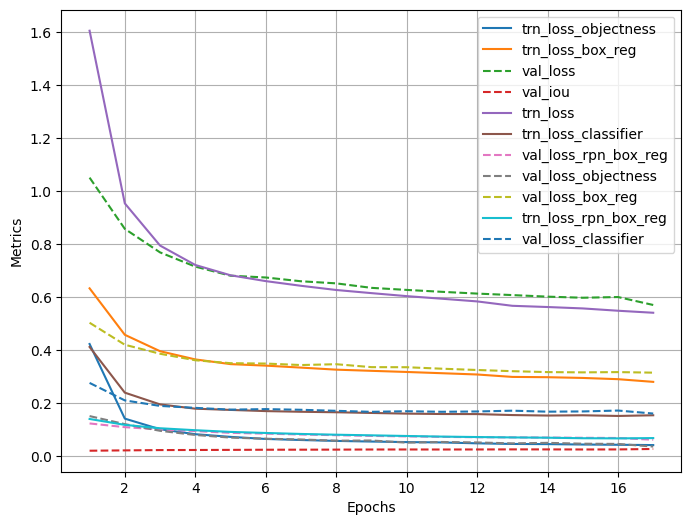

In [68]:
log.plot_epochs()

In [88]:
indices = [(i+1)/16 for i in range(256)]
indices

[0.0625,
 0.125,
 0.1875,
 0.25,
 0.3125,
 0.375,
 0.4375,
 0.5,
 0.5625,
 0.625,
 0.6875,
 0.75,
 0.8125,
 0.875,
 0.9375,
 1.0,
 1.0625,
 1.125,
 1.1875,
 1.25,
 1.3125,
 1.375,
 1.4375,
 1.5,
 1.5625,
 1.625,
 1.6875,
 1.75,
 1.8125,
 1.875,
 1.9375,
 2.0,
 2.0625,
 2.125,
 2.1875,
 2.25,
 2.3125,
 2.375,
 2.4375,
 2.5,
 2.5625,
 2.625,
 2.6875,
 2.75,
 2.8125,
 2.875,
 2.9375,
 3.0,
 3.0625,
 3.125,
 3.1875,
 3.25,
 3.3125,
 3.375,
 3.4375,
 3.5,
 3.5625,
 3.625,
 3.6875,
 3.75,
 3.8125,
 3.875,
 3.9375,
 4.0,
 4.0625,
 4.125,
 4.1875,
 4.25,
 4.3125,
 4.375,
 4.4375,
 4.5,
 4.5625,
 4.625,
 4.6875,
 4.75,
 4.8125,
 4.875,
 4.9375,
 5.0,
 5.0625,
 5.125,
 5.1875,
 5.25,
 5.3125,
 5.375,
 5.4375,
 5.5,
 5.5625,
 5.625,
 5.6875,
 5.75,
 5.8125,
 5.875,
 5.9375,
 6.0,
 6.0625,
 6.125,
 6.1875,
 6.25,
 6.3125,
 6.375,
 6.4375,
 6.5,
 6.5625,
 6.625,
 6.6875,
 6.75,
 6.8125,
 6.875,
 6.9375,
 7.0,
 7.0625,
 7.125,
 7.1875,
 7.25,
 7.3125,
 7.375,
 7.4375,
 7.5,
 7.5625,
 7.625,
 7.6875,

In [96]:
k

'trn_loss'

In [155]:
def get_epoch(arr):
    a = []
    for i in range(17):
        b = arr[i*16: (i+1) * 16]
        if len(b):
            a.append( sum(b) / len(b) )

    return a
        

get_epoch(log.history(k))

[0.12226889189332724,
 0.107392608653754,
 0.09931305469945073,
 0.09305486222729087,
 0.08707159711048007,
 0.0835410300642252,
 0.08074063574895263,
 0.0779823805205524,
 0.07500484539195895,
 0.07332455646246672,
 0.07167750783264637,
 0.0702214827761054,
 0.06959794275462627,
 0.06924930168315768,
 0.06805307883769274,
 0.0672542629763484]

Text(0, 0.5, 'Loss')

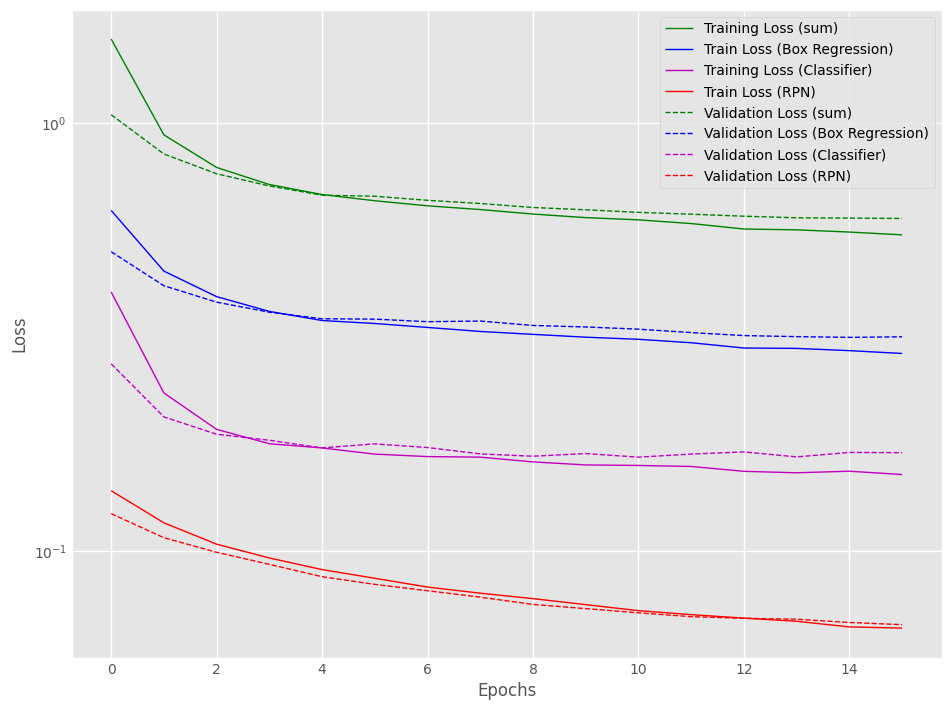

In [156]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,8))

ax.set_yscale('log')
color = 'g'

for k, v in legend_labels.items():
    if 'rpn_box' in k:
        color = 'r'
    elif 'loss_box' in k:
        color = 'b'
    elif 'classifier' in k:
        color = 'm'
    elif 'object' in k:
        continue
    else:
        color='g'
    if 'val' in k:
        linestyle = 'dashed'
    else:
        linestyle = 'solid'

    
    # plt.plot(xnew, power_smooth)
    # ax.plot(indices, log.history(k) , label=legend_labels[k], color=color, linewidth=1, linestyle=linestyle)
    ax.plot( get_epoch(log.history(k)) , label=legend_labels[k], color=color, linewidth=1, linestyle=linestyle)
    
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

In [39]:
scores.shape, boxes.shape

((24,), (24, 4))

In [172]:
y

{'Train Loss Objectness'}

In [24]:
model = fasterrcnn(pretrained = True)

for p in model.backbone.parameters():
    p.requires_grad = False


in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats,
                                                   2)

model.load_state_dict(torch.load('model\\15.pth'))

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [26]:
model_paths = glob.glob('model\\*.pth')

model_paths.sort()

In [469]:
model_paths

['model\\0.pth',
 'model\\1.pth',
 'model\\10.pth',
 'model\\11.pth',
 'model\\12.pth',
 'model\\13.pth',
 'model\\14.pth',
 'model\\15.pth',
 'model\\2.pth',
 'model\\3.pth',
 'model\\4.pth',
 'model\\5.pth',
 'model\\6.pth',
 'model\\7.pth',
 'model\\8.pth',
 'model\\9.pth']

In [493]:
del model
torch.cuda.empty_cache() 

In [494]:
import gc
gc.collect()

3741

In [498]:
results

{'model\\0.pth': {'map': tensor(0.15290),
  'map_50': tensor(0.35851),
  'map_75': tensor(0.11678),
  'map_small': tensor(0.00031),
  'map_medium': tensor(0.15270),
  'map_large': tensor(0.22616),
  'mar_1': tensor(0.00548),
  'mar_10': tensor(0.05300),
  'mar_100': tensor(0.19678),
  'mar_small': tensor(0.03030),
  'mar_medium': tensor(0.19167),
  'mar_large': tensor(0.33295),
  'map_per_class': tensor(-1.),
  'mar_100_per_class': tensor(-1.),
  'classes': tensor(1, dtype=torch.int32)}}

In [34]:
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm

In [35]:
results = {}
for m_path in model_paths:
    model.load_state_dict(torch.load(m_path))
    model.to(device)
    
    with torch.no_grad():
        model.eval()
        metric = MeanAveragePrecision(iou_type="bbox")
        for ix, batch in tqdm(enumerate(test_loader)):
                X,y = batch
                # move batch to device
                X = [x.to(device) for x in X]
                y = [{k: v.to(device) for k, v in t.items()} for t in y]
                for i in range(len(y)):
                    y[i]['boxes'] = y[i]['boxes'][y[i]['labels'] == 1]
                    y[i]['labels'] = y[i]['labels'][y[i]['labels'] == 1]
            
                # zero grads
                optimizer.zero_grad()
                predict = model(X,y)
                metric.update(predict, y)

                break

        results[m_path.split('\\')[1]] = metric.compute()


0it [00:00, ?it/s]C:\Users\sali632\.conda\envs\ml\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
0it [00:06, ?it/s]
0it [00:01, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:01, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [68]:
s = np.zeros(( 16, 15))

for k, v in results.items():
    s[int(k.split('.')[0]):, ] = [v.item() for i, v in  v.items()]


In [73]:
keys = [i for i, v in  v.items()]

In [92]:
keys[0] = 'mAP'
keys[1] = 'mAP 50%'
keys[2] = 'mAP 75%'

In [113]:
s[5, 1]

0.4302297532558441

In [111]:
np.argmax(s[:, 2])

5

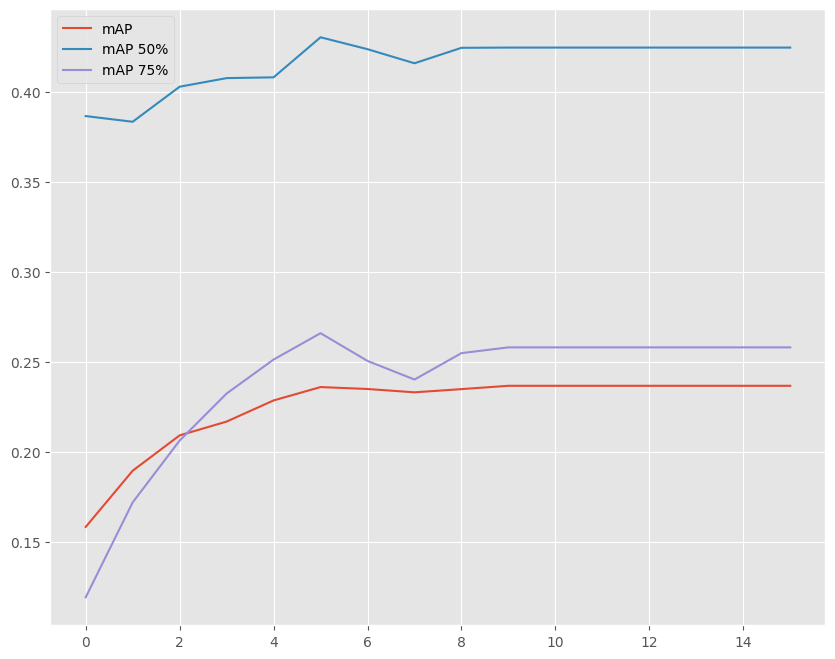

In [93]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(s[:, 0], label=keys[0])
ax.plot(s[:, 1], label=keys[1])
ax.plot(s[:, 2], label=keys[2])


ax.legend()

In [99]:
m_path

'model\\9.pth'

In [100]:
model.load_state_dict(torch.load('model\\5.pth'))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

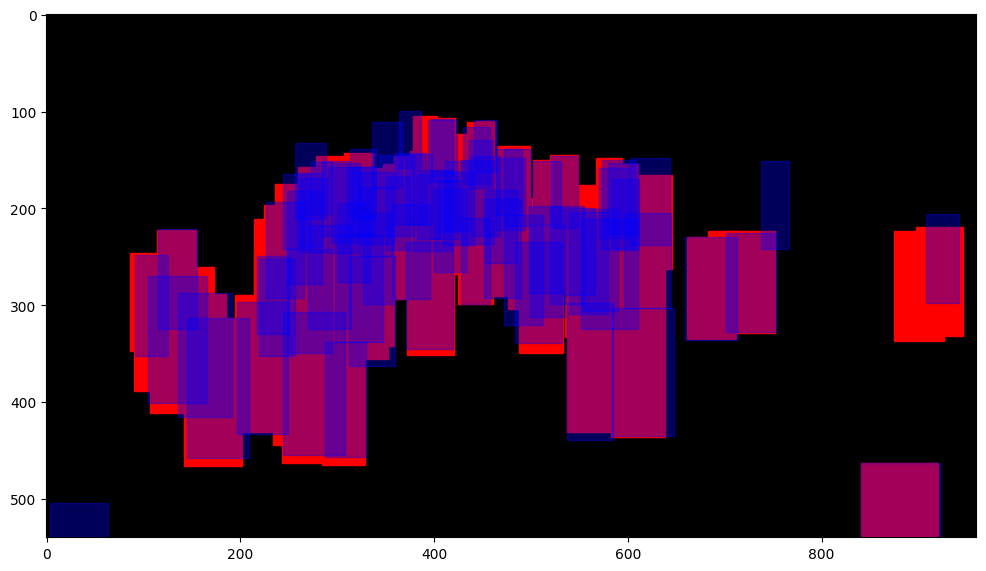

In [105]:
plt.style.use('default')
fig, ax = plt.subplots(figsize = [12, 12])


# ax.imshow(X[1].detach().cpu().permute(1, 2, 0).numpy(),
#           interpolation='none' )

ax.imshow(np.zeros_like(X[0].detach().cpu().permute(1, 2, 0).numpy()),
          interpolation='none' )

boxes, _, scores = decode_prediction(predict[1], 0, .5)

target_box = y[0]['boxes'][y[0]['labels'] == 1]
pred_box = torch.tensor(boxes).to(device)



for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "r")
    ax.add_patch(rect)
    # ax.text(b[0].astype(int),
    #             b[1].astype(int) - 5,
    #             " {:.3f}".format(
    #             scores[i]), color = "r")


for i, b in enumerate(target_box.detach().cpu().numpy()):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "b",
                             facecolor = "b", fill=True, alpha=0.2)
    ax.add_patch(rect)
    # ax.text(b[0].astype(int),
    #             b[1].astype(int) - 5,
    #             " {:.3f}".format(
        #             scores[i]), color = "r")

# torchvision.ops.box_iou(target_box, pred_box).max(axis=1).values.mean()


In [335]:
pred_box[pred_box > 800]

tensor([821.95691, 814.60522, 856.52008, 851.52991, 896.33966],
       device='cuda:0')

In [189]:
y[0]['boxes']

tensor([[2.7200e+02, 5.0450e+02, 3.5650e+02, 5.4050e+02],
        [5.0000e-01, 5.0450e+02, 5.0000e+01, 5.4050e+02],
        [1.8950e+02, 2.8100e+02, 2.3400e+02, 4.0200e+02],
        [2.2250e+02, 2.7500e+02, 2.6750e+02, 4.1200e+02],
        [2.5800e+02, 1.5200e+02, 2.9600e+02, 2.3650e+02],
        [1.6950e+02, 1.7600e+02, 1.9850e+02, 2.7100e+02],
        [2.2900e+02, 1.8850e+02, 2.5600e+02, 2.6600e+02],
        [1.4600e+02, 1.4550e+02, 1.7850e+02, 2.2300e+02],
        [2.3400e+02, 3.3500e+02, 2.9900e+02, 4.9800e+02],
        [4.8800e+02, 9.3000e+01, 5.1300e+02, 1.5800e+02],
        [2.2000e+02, 2.5400e+02, 2.7050e+02, 3.6700e+02],
        [7.5550e+02, 1.9350e+02, 8.0000e+02, 2.9900e+02],
        [3.9050e+02, 3.2350e+02, 4.4050e+02, 4.8400e+02],
        [8.7450e+02, 2.0950e+02, 9.1100e+02, 3.1650e+02],
        [5.3750e+02, 1.9800e+02, 5.7250e+02, 3.0200e+02],
        [2.5700e+02, 2.3850e+02, 2.9800e+02, 3.5950e+02],
        [3.0550e+02, 2.8350e+02, 3.7200e+02, 4.3500e+02],
        [8.625

In [397]:
import torchmetrics.functional.detection as dt
dir(dt)

['_TORCHVISION_AVAILABLE',
 '_TORCHVISION_GREATER_EQUAL_0_13',
 '_TORCHVISION_GREATER_EQUAL_0_8',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_deprecated',
 '_panoptic_quality_common',
 'ciou',
 'complete_intersection_over_union',
 'diou',
 'distance_intersection_over_union',
 'generalized_intersection_over_union',
 'giou',
 'intersection_over_union',
 'iou',
 'modified_panoptic_quality',
 'panoptic_qualities',
 'panoptic_quality']

In [404]:
import torchmetrics

In [406]:
dir(torchmetrics.detection)

['CompleteIntersectionOverUnion',
 'DistanceIntersectionOverUnion',
 'GeneralizedIntersectionOverUnion',
 'IntersectionOverUnion',
 'MeanAveragePrecision',
 'ModifiedPanopticQuality',
 'PanopticQuality',
 '_TORCHVISION_GREATER_EQUAL_0_13',
 '_TORCHVISION_GREATER_EQUAL_0_8',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_deprecated',
 'ciou',
 'diou',
 'giou',
 'helpers',
 'iou',
 'mean_ap',
 'panoptic_qualities']

In [402]:
import torch
from torchmetrics.detection import IntersectionOverUnion

C:\Users\sali632\AppData\Local\Temp\ipykernel_1556\1517245243.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  generalized_intersection_over_union(torch.tensor(boxes).to(device), torch.tensor(y[0]['boxes'][y[0]['labels'] == 1]).to(device))


tensor(-0.69351, device='cuda:0')

In [213]:
target_box.shape

torch.Size([98, 4])

In [212]:
boxes.shape

(52, 4)

In [207]:
target_box.device

device(type='cuda', index=0)

In [390]:
torchvision.ops.box_iou(target_box, pred_box).max(axis=1).values.shape

torch.Size([128])

In [391]:
np.set_printoptions(suppress=True)
torch.set_printoptions(precision=5, sci_mode =False)

In [392]:
preds = torch.tensor(
    [
        [296.55, 93.96, 314.97, 152.79],
        [328.94, 97.05, 342.49, 122.98],
        [356.62, 95.47, 372.33, 147.55],
        [328.94, 97.05, 342.49, 122.98],
        [356.62, 95.47, 372.33, 147.55],
        [296.55, 93.96, 314.97, 152.79],
        [328.94, 97.05, 342.49, 122.98],
        [352.62, 95.47, 372.33, 147.55],
        [328.94, 97.05, 342.49, 122.98],
        [356.62, 95.47, 372.33, 147.55],
    ]
)
target = torch.tensor(
    [
        [300.00, 100.00, 315.00, 150.00],
        [330.00, 100.00, 350.00, 125.00],
        [350.00, 100.00, 375.00, 150.00],
    ]
)
# box_iou( target, preds).sum(axis=1).mean()
torchvision.ops.box_iou(target, preds).max(axis=1).values.


torch.Size([3])

In [94]:
s['map']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

{'map': tensor(0.13143),
 'map_50': tensor(0.21974),
 'map_75': tensor(0.15589),
 'map_small': tensor(0.),
 'map_medium': tensor(0.12753),
 'map_large': tensor(0.20863),
 'mar_1': tensor(0.00342),
 'mar_10': tensor(0.03382),
 'mar_100': tensor(0.14015),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.13739),
 'mar_large': tensor(0.21111),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1], dtype=torch.int32)}

In [102]:
def decode_prediction(prediction, 
                      score_threshold = 0.8, 
                      nms_iou_threshold = 0.5):
    """
    Inputs
        prediction: dict
        score_threshold: float
        nms_iou_threshold: float
    Returns
        prediction: tuple
    """
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]
    # Remove any low-score predictions.
    if score_threshold is not None:
        want = scores > score_threshold
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    # Remove any overlapping bounding boxes using NMS.
    if nms_iou_threshold is not None:
        want = torchvision.ops.nms(boxes = boxes, scores = scores, 
                                iou_threshold = nms_iou_threshold)
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    return (boxes.detach().cpu().numpy(), 
            labels.detach().cpu().numpy(), 
            scores.detach().cpu().numpy())
    

In [ ]:
decode_prediction()